In [1]:
import glmhmm 
import numpy as np
import sys
sys.path.append('/src/tools/flytrack/model/')
print(sys.path)
from fitting import *
from analysis import find_permutation, evaluate_classification, calculate_match_rate, matrix_comp

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/src/tools/flytrack/model/']


# Initialize data

## load trajectory and neural data

based on /src/tools/pybounds/examples/observability_analysis_dynamic_wind.ipynb

In [2]:
obs_pkls = ['/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/noisy3x5b5_original_inits_observability_test.pkl',
            '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_17519_6aca800e09d4942c5d296ae7157fcf8b/noisy3x5b5_observability_test.pkl']
eval_pkls = [obs_pkl.replace("_observability_test.pkl", ".pkl") for obs_pkl in obs_pkls]

# load pkl file
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import tamagotchi.eval.log_analysis as log_analysis

with open(obs_pkls[0], 'rb') as f_handle:
    observability_tupl = pickle.load(f_handle)
    print(len(observability_tupl))
with open(eval_pkls[0], 'rb') as f_handle:
    # based on open_loop_perturbation.py
    dataset = 'noisy3x5b5'
    eval_folder = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/'
    # eval_folder = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_17519_6aca800e09d4942c5d296ae7157fcf8b/'
    selected_df = log_analysis.get_selected_df(eval_folder, [dataset],
                                            n_episodes_home=240,
                                            n_episodes_other=240,  
                                            balanced=False,
                                            oob_only=False,
                                            verbose=True,
                                            log_fname='/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/noisy3x5b5_original_inits.pkl')

    traj_df_stacked, stacked_neural_activity = log_analysis.get_traj_and_activity_and_stack_them(selected_df, 
                                                                                                obtain_neural_activity = True, 
                                                                                                obtain_traj_df = True, 
                                                                                                get_traj_tmp = True,
                                                                                                extended_metadata = True) # get_traj_tmp 
    print(traj_df_stacked.shape)
    print(stacked_neural_activity.shape)
# for item in observability_tupl:
#     EV_no_nan, t_sim, x_sim, window_size, eps_idx = item
    
ls_EV_no_nan, ls_t_sim, ls_x_sim, ls_window_size, ls_eps_idx = zip(*observability_tupl)

# Preprocess the trajectory data
# select episodes that have observability matrices
eps_at = [True if ep_i in ls_eps_idx else False for ep_i in traj_df_stacked['ep_idx'] ]
subset_traj_df_stacked = traj_df_stacked[eps_at]
subset_stacked_neural_activity = stacked_neural_activity[eps_at]

# for every episode, drop the last row
subset_traj_df_stacked.reset_index(drop=True, inplace=True)
last_rows = subset_traj_df_stacked.groupby('ep_idx').tail(1).index
print('dropping', len(last_rows), 'rows')
# drop the last row of each episode
filtered_df = subset_traj_df_stacked.drop(index=last_rows)
filtered_neural_activity = np.delete(subset_stacked_neural_activity, last_rows, axis=0)

# calculate time since last wind change
    # based on /src/JH_boilerplate/agent_evaluatiion/traj_analysis_preprocess.ipynb
filtered_df = filtered_df.groupby('ep_idx').apply(log_analysis.calc_time_since_last_wind_change).reset_index(drop=True)

# create time column in filtered_df to match with EV_no_nan, starting from 0 to trial end 
filtered_df['time'] = filtered_df.groupby('ep_idx')['t_val'].transform(lambda x: x - x.iloc[0])
filtered_df['time'] = filtered_df['time'].round(2)

print("filtered_df shape", filtered_df.shape)
print("filtered_neural_activity shape", filtered_neural_activity.shape)

40
Found                     idx  ep_length  log
dataset    outcome                     
noisy3x5b5 HOME     160        160  160
           OOB       74         74   74
           OOT        6          6    6 in /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/noisy3x5b5_original_inits.pkl, after filter by min 0 steps
Found                     idx  ep_length  log
dataset    outcome                     
noisy3x5b5 HOME     160        160  160
           OOB       74         74   74
           OOT        6          6    6 in /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/noisy3x5b5_original_inits.pkl, after selecting specific number of episodes
model_dir /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_

240it [00:10, 23.09it/s]


(40891, 89)
(40891, 64)
dropping 40 rows
filtered_df shape (10608, 91)
filtered_neural_activity shape (10608, 64)


## load observability data

In [3]:
# Preprocess the EV data 
# stack the EV data
ls_EV_no_nan = [df.assign(ep_idx=ep_idx) for df, ep_idx in zip(ls_EV_no_nan, ls_eps_idx)]
EV_no_nan = pd.concat(ls_EV_no_nan)
print(EV_no_nan.shape)
# Merge with filtered_dfa
EV_no_nan['time'] = EV_no_nan['time'].round(2)
EV_no_nan = EV_no_nan.merge(filtered_df[['ep_idx', 'time', 'time_since_last_wind_change', 'odor_01']], on=['ep_idx', 'time'], how='inner')
print(EV_no_nan.shape)
# EV_no_nan.sort_values(by=['ep_idx', 'time'], inplace=True)
# EV_no_nan.groupby('ep_idx')['time'].diff().value_counts() # checks out

(10608, 7)
(10608, 9)


## Construct obs df

In [4]:
# Preprocess action data
# get speed and acceleration
obs_df = pd.DataFrame()
obs_df['ep_idx'] = filtered_df['ep_idx']
obs_df['step'] = filtered_df['step'] # squashed action
obs_df['step_dt'] = obs_df.groupby('ep_idx')['step'].diff()
obs_df['speed'] = filtered_df['step']*2 # in m/s unit
obs_df['acceleration'] = obs_df.groupby('ep_idx')['speed'].diff()
obs_df['turn'] = filtered_df['turn']
obs_df['angular_velocity_turn'] = ((filtered_df['turn'] - 0.5)*2) * (6*np.pi) # in rad/s unit

# obs_df['acceleration'] = obs_df['acceleration'].fillna(0) # TODO check timing 

# calculate angular velocity and angular acceleration
obs_df['heading_phi'] = np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False)
obs_df['heading_phi_unwrap'] = np.unwrap(np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False))
obs_df['angular_velocity'] = obs_df.groupby('ep_idx')['heading_phi_unwrap'].diff()
obs_df['angular_acceleration'] = obs_df.groupby('ep_idx')['angular_velocity'].diff()
# obs_df['angular_acceleration'] = obs_df['angular_acceleration'].fillna(0) # TODO check timing

obs_df.head()
# obs_df['speed'].hist()


,ep_idx,step,step_dt,speed,acceleration,turn,angular_velocity_turn,heading_phi,heading_phi_unwrap,angular_velocity,angular_acceleration
0,83,0.243873,NaN,0.487745,NaN,0.096631,-15.206658,-0.316805,-0.316805,NaN,NaN
1,83,0.352573,0.108700,0.705146,0.217401,0.077069,-15.944136,-0.648975,-0.648975,-0.332170,NaN
2,83,0.449508,0.096935,0.899016,0.193870,0.115408,-14.498775,-0.951033,-0.951033,-0.302058,0.030112
3,83,0.395366,-0.054142,0.790732,-0.108284,0.122506,-14.231187,-1.247516,-1.247516,-0.296483,0.005575
4,83,0.372357,-0.023009,0.744713,-0.046018,0.107094,-14.812205,-1.556103,-1.556103,-0.308588,-0.012105


## Construct input df for glmhmm

In [5]:
input_df = pd.DataFrame()
# observations of the agent
input_df['ep_idx'] = filtered_df['ep_idx']
input_df['app_wind_x'] = filtered_df['wind_x_obs']
input_df['app_wind_y'] = filtered_df['wind_y_obs']
input_df['odor'] = filtered_df['odor_eps_log']
input_df['allo_head_phi_x'] = filtered_df['agent_angle_x']
input_df['allo_head_phi_y'] = filtered_df['agent_angle_y']
input_df['ego_drift_x'] = filtered_df['ego_course_direction_x']
input_df['ego_drift_y'] = filtered_df['ego_course_direction_y']
# possible latents to include
input_df['min_EV_zeta'] = EV_no_nan['zeta']
input_df['time_since_last_wind_change'] = EV_no_nan['time_since_last_wind_change']
input_df['acceleration'] = obs_df['acceleration']
input_df['angular_acceleration'] = obs_df['angular_acceleration']

input_df.head()


,ep_idx,app_wind_x,app_wind_y,odor,allo_head_phi_x,allo_head_phi_y,ego_drift_x,ego_drift_y,min_EV_zeta,time_since_last_wind_change,acceleration,angular_acceleration
0,83,2.123532,5.307983e-13,0.003922,0.950235,-0.311533,0.862312,0.506378,0.073294,0.04,NaN,NaN
1,83,1.702489,7.969043e-13,0.004154,0.796704,-0.604370,0.812999,0.582265,0.073294,0.00,0.217401,NaN
2,83,1.327018,1.034208e-12,0.006039,0.580843,-0.814016,0.842580,0.538571,0.073294,0.04,0.193870,0.030112
3,83,1.536733,9.016646e-13,0.006771,0.317679,-0.948198,0.775901,0.630855,0.073294,0.08,-0.108284,0.005575
4,83,1.625858,8.453364e-13,0.007782,0.014692,-0.999892,0.753328,0.657645,0.073294,0.12,-0.046018,-0.012105


## drop NaNs

In [6]:
# drop rows with NaN
input_df.dropna(inplace=True)
print(input_df.shape)
obs_df.dropna(inplace=True)
print(obs_df.shape)

(10528, 12)
(10528, 11)


# init. model

In [27]:
import importlib
import glmhmm
importlib.reload(glmhmm)

session_length = 0
# session_length = 300

# A_true_all = np.zeros((num_models, K, K))
# w_true_all = np.zeros((num_models, K, D+1, dim_output))
# pi0_true_all = np.zeros((num_models, K))

if not session_length:
    sess = None
K=3 # number of states
input_names = ['app_wind_x', 'app_wind_y', 
               'odor', 
               'allo_head_phi_x', 'allo_head_phi_y', 
               'ego_drift_x', 'ego_drift_y'
               # 'min_EV_zeta', 'time_since_last_wind_change', 'acceleration', 'angular_acceleration'
               ]
D=len(input_names) # number of input features
obs_names = ['step', 'turn'] # TODO try these variables in physical units
dim_output=len(obs_names) # number of output features
covar_epsilon=1e-3

Y = obs_df[obs_names][obs_df['train_test_label']=='train'].values[:10]
X = input_df[input_names][input_df['train_test_label']=='train'].values[:10]


# if session_length: # trim the data to have equal length sessions
#     num_sessions = Y.shape[0] // N 
#     sess = np.arange(0, Y.shape[0], 300)
#     Y = Y[:N*num_sessions]
#     X = X[:N*num_sessions]


N=X.shape[0] # length of training data
m = glmhmm.GLMHMM(N, K, D, dim_output, covar_epsilon)

A_init=m.transition_matrix
w_init=m.w
pi0_init  = m.pi0
init_states_seq = m.mostprob_states(X, Y).astype(int)

# A_init_all[i] = A_init
# w_init_all[i] = w_init
# pi0_init_all[i] = pi0_init
# init_states_seq_all[i] = init_states_seq

lls_pred,A_pred,w_pred,pi0_pred = m.fit(Y,X,A_init,w_init, pi0=pi0_init, fit_init_states=True, 
                                        sess=sess)

KeyError: 'train_test_label'

## load fitted model

In [7]:
import sys
sys.path.append('/src/tools/flytrack/model/')
print(sys.path)
from fitting import *
from analysis import find_permutation, evaluate_classification, calculate_match_rate, matrix_comp
# from visualize import plot_model_params, plot_loglikelihoods, plot_weights # NOTE dependency issues - weixuan new scripts same name as original; original scripts not included 

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/src/tools/flytrack/model/']


In [8]:
# find saved models in the directory
result_dir = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/'
# result_dir = '/src/tools/flytrack/model/glmhmm/'
# find files that end in npz
import os
import re
import numpy as np

files = os.listdir(result_dir)
# sort
files.sort()
files = [f for f in files if f.endswith('.npz')]
print(f"found {len(files)} files")

# load files 
keys = ['A_init', 'w_init', 'pi0_init', 'A_pred', 'w_pred', 'pi0_pred', 'train_idx', 'test_idx', 'input_names', 'obs_names', 'lls_pred']
A_init_all = []
w_init_all = []
pi0_init_all = []
A_pred_all = []
w_pred_all = []
pi0_pred_all = []
train_idx_all = []
test_idx_all = []
input_names_all = []
obs_names_all = []
lls_pred_all = []


fitted_models = [A_init_all, w_init_all, pi0_init_all, A_pred_all, w_pred_all, pi0_pred_all, train_idx_all, test_idx_all, input_names_all, obs_names_all, lls_pred_all]
for f in files:
    # print(f)
    f_loaded = np.load(os.path.join(result_dir, f))
    for i, key in enumerate(keys):
        if key in f_loaded:
            # print(f"{key} found in {f}")
            loaded_shape = f_loaded[key].shape
            shapes = [j.shape[-len(loaded_shape):] for j in fitted_models[i]]
            if loaded_shape not in shapes:
                if str(f_loaded[key].dtype).startswith('<U'):
                    arr = np.zeros((1, *f_loaded[key].shape), dtype='<U15')
                else:
                    arr = np.zeros((1, *f_loaded[key].shape))
                arr[0] = f_loaded[key]
                fitted_models[i].append(arr)
            else:
                idx = shapes.index(f_loaded[key].shape)
                arr = fitted_models[i][idx]
                f_key = np.expand_dims(f_loaded[key], axis=0)
                arr = np.vstack([arr, f_key])
                fitted_models[i][idx] = arr
        else:
            print(f"{key} not in {f}")
print('shape dimensions: ("num_models, num_states, num_obs_features")')
for j, ls in enumerate(fitted_models):
    for i, arr in enumerate(ls):
        print(keys[j], "shape", arr.shape)

found 18 files
shape dimensions: ("num_models, num_states, num_obs_features")
A_init shape (6, 2, 2)
A_init shape (6, 3, 3)
A_init shape (3, 4, 4)
A_init shape (3, 5, 5)
w_init shape (6, 2, 8, 2)
w_init shape (6, 3, 8, 2)
w_init shape (3, 4, 8, 2)
w_init shape (3, 5, 8, 2)
pi0_init shape (6, 2)
pi0_init shape (6, 3)
pi0_init shape (3, 4)
pi0_init shape (3, 5)
A_pred shape (6, 2, 2)
A_pred shape (6, 3, 3)
A_pred shape (3, 4, 4)
A_pred shape (3, 5, 5)
w_pred shape (6, 2, 8, 2)
w_pred shape (6, 3, 8, 2)
w_pred shape (3, 4, 8, 2)
w_pred shape (3, 5, 8, 2)
pi0_pred shape (6, 2)
pi0_pred shape (6, 3)
pi0_pred shape (3, 4)
pi0_pred shape (3, 5)
train_idx shape (18, 36)
test_idx shape (18, 4)
input_names shape (18, 7)
obs_names shape (18, 2)
lls_pred shape (18, 250)


# evaluate models 

## load test data

In [ ]:
# predict state sequence # TODO picking out test idx need to change - all the same as of now so skip
        
test_idx = test_idx_all[0][0]
input_names = input_names_all[0][0]
obs_names = obs_names_all[0][0]
X_test = input_df[input_names][input_df['ep_idx'].isin(test_idx)].values
Y_test = obs_df[obs_names][obs_df['ep_idx'].isin(test_idx)].values
print(X_test.shape, Y_test.shape)

(1095, 7) (1095, 2)
1095 3 8 2


(1095,)

## predict states

In [46]:
pi0_pred_all

[array([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]]),
 array([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]),
 array([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]]),
 array([[0.00000000e+000, 4.18981465e-136, 1.02280484e-233,
         1.00000000e+000, 3.10281348e-082],
        [0.00000000e+000, 4.18981465e-136, 1.02280484e-233,
         1.00000000e+000, 3.10281348e-082],
        [0.00000000e+000, 4.18981465e-136, 1.02280484e-233,
         1.00000000e+000, 3.10281348e-082]])]

In [ ]:

for model_i, w_pred in enumerate(w_pred_all):
    if w_pred.shape[1] == 3:
        w_pred_K3 = w_pred
        A_pred_K3 = A_pred_all[model_i]
        pi0_pred_K3 = pi0_pred_all[model_i]
        break
    
model_i = 0
w_pred = w_pred_K3[0]
A_pred = A_pred_K3[0]
pi0_pred = pi0_pred_K3[0] # TODO this is not saved normally
N = X_test.shape[0] 
K = A_pred_K3.shape[1]
D = X_test.shape[1] + 1 
dim_output = Y_test.shape[1]
covar_epsilon=0.2 # TODO: this needs to be saved after training
print(N, K, D, dim_output)
m = GLMHMM(N, K, D, dim_output, covar_epsilon)
m.transition_matrix = A_pred
m.w = w_pred
m.pi0 = pi0_pred
pred_seq = m.mostprob_states(X_test, Y_test).astype(int)

pred_seq.shape

1095 3 8 2


(1095,)

## visualize predicted states

In [42]:
pred_seq.sum(axis=0)

0

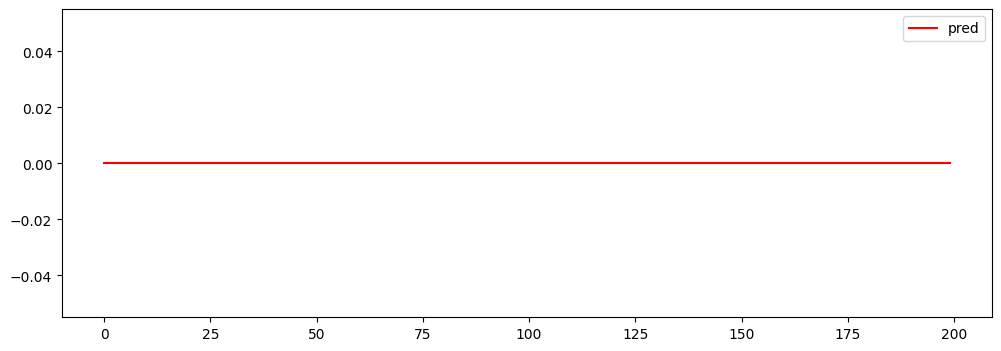

In [35]:
timebin=200
cmap = 'viridis'
vmin, vmax = 0, np.max(pred_seq)

plt.figure(figsize=(12, 4))
# plt.title(f"true{true_i}, pred{pred_i}")
plt.plot(range(200), pred_seq[:200], 'red', label='pred')
plt.legend()



# plt.figure(figsize=(8, 6))
# plt.subplot(311)
# plt.imshow(pred_seq, aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)
# plt.xlim(0, timebin)
# plt.ylabel("$z_{\\mathrm{true}}$")
# plt.yticks([])


# visualize GLM weights

## plot one model

In [5]:
w_pred_K3 = w_pred_all[0] # shape (3, 3, 8, 2): model, K, D+1, dim_output
w_pred = w_pred_K3[2] # shape (3, 8, 2): K, D+1, dim_output

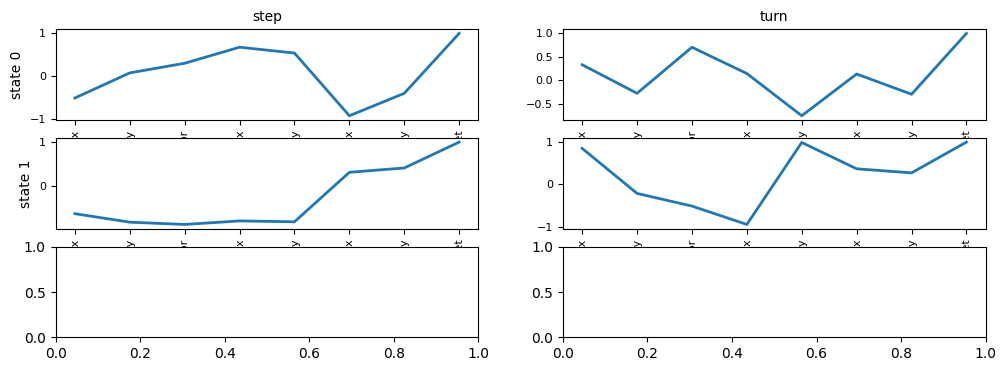

In [6]:
# plot the inferred weights probabilities
# fig, axes = plt.f
fig, axes = plt.subplots(3,2)
output_names=['step', 'turn']
for state_i in range(w_pred.shape[0]):
    for output_i in range(w_pred.shape[2]):
    # state_i = 0
    # output_i = 0
        ax = axes[state_i, output_i]

        fig.set_size_inches(12, 4)
        colors = np.array([[0,0,0]])/255
        xlabels = ['app_wind_x', 'app_wind_y', 
                    'odor', 
                    'allo_head_phi_x', 'allo_head_phi_y', 
                    'ego_drift_x', 'ego_drift_y', 'offset'
                    # 'min_EV_zeta', 'time_since_last_wind_change', 'acceleration', 'angular_acceleration'
                    ]
        # w_pred.shape (3, 8, 2): K, D+1, dim_output
        style = '-'
        ax.plot(w_pred[state_i,:,output_i], style,linewidth=2) #,color=color[i] label=label[i],
        # label x axis by name
        ax.set_xticks(np.arange(0,len(xlabels)))
        ax.set_xticklabels(xlabels,rotation=90, fontsize=8)
        # change y ticks font
        ax.tick_params(axis='y', labelsize=8)
        # change y label font
        if output_i == 0:
            ax.set_ylabel(f"state {state_i}" , fontsize=10)
        if state_i == 0:
            ax.set_title(f'{output_names[output_i]}', fontsize=10)
# label the first column
# axes[0,0].set_title('state 0')
# axes[1,0].set_title('state 1')
# axes[2,0].set_title('state 2')
# plt.tight_layout()

    
# if color is not None:
#     if error is not None:
#         error = error[(w.shape[0])*(w.shape[0]-1):]
#         error = np.reshape(error,(w.shape[0],w.shape[1]))
#         for i in range(w.shape[0]):
#             ax.errorbar(np.arange(w[i,:].shape[0]),w[i,:],yerr=error[i,:],fmt=style,color=color[i],label=label[i],linewidth=2)
#     else:
#         for i in range(w.shape[0]):
#             ax.plot(w[i,:],style,color=color[i],label=label[i],linewidth=2)
# else:
#     if error is not None:
#         ax.errorbar(w.T,yerr=error,fmt=style,label=label)
#     else:
#         ax.plot(w.T,style,label=label)
# ax.set_ylabel('weight')
# if xlabels:
#     ax.plot(xlabels,np.zeros((len(xlabels),1)),'k--')
#     ax.set_xticks(np.arange(0,len(xlabels)))
#     ax.set_xticklabels(xlabels,rotation=90)
        
        
# plot_weights(w_pred.reshape(1,-1),axes[0],switch=True,xlabels=xlabels,style='.-',color=colors)
# axes[0].text(0.43,-0.25,'prev choice',transform=axes[0].transAxes)
# axes[0].set_title('indirect pathway')
# axes[0].set_ylim([-1,1])
# axes[0].set_yticks(np.arange(-1,1.5,0.5))



## plot all K3 models

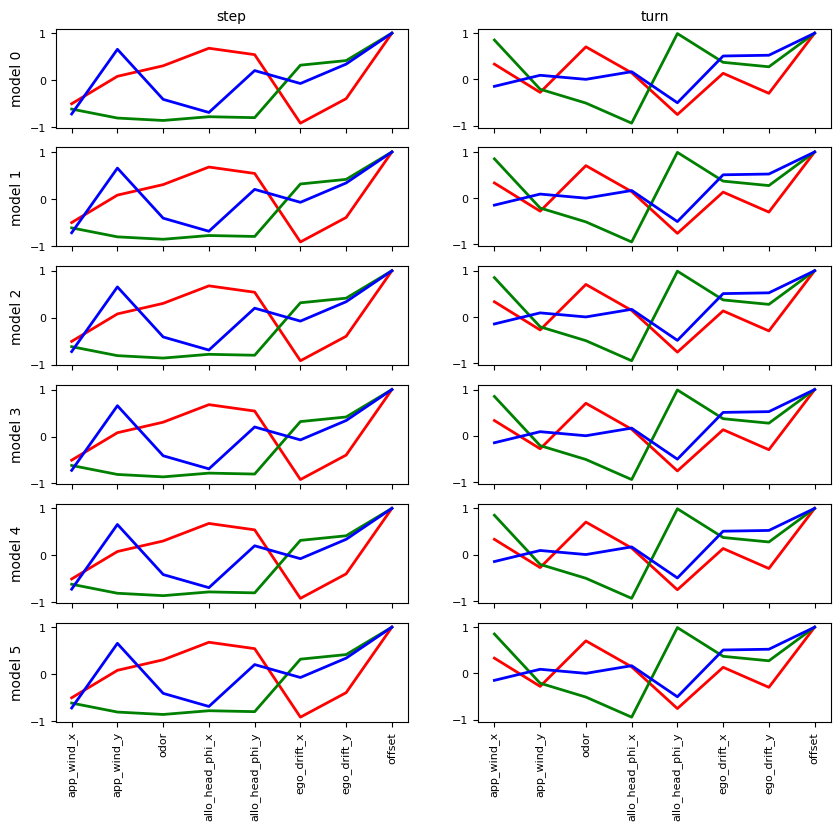

In [8]:
for w_pred in w_pred_all:
    if w_pred.shape[1] == 3:
        w_pred_K3 = w_pred

# plot the inferred weights probabilities


fig, axes = plt.subplots(w_pred_K3.shape[0],2)
# set figure size
fig.set_size_inches(10,9)
output_names=['step', 'turn']
# set up a colors obj with 3 distinct colors , without using sns
colors = ['r', 'g', 'b']
labels = ['state 0', 'state 1', 'state 2']
for model_i in range(w_pred_K3.shape[0]):
    w_pred = w_pred_K3[model_i] # shape (3, 8, 2): K, D+1, dim_output
    for state_i in range(w_pred.shape[0]):
        for output_i in range(w_pred.shape[2]):
            ax = axes[model_i, output_i] # each model has its own row
            xlabels = ['app_wind_x', 'app_wind_y', 
                        'odor', 
                        'allo_head_phi_x', 'allo_head_phi_y', 
                        'ego_drift_x', 'ego_drift_y', 'offset'
                        # 'min_EV_zeta', 'time_since_last_wind_change', 'acceleration', 'angular_acceleration'
                        ]
            # w_pred.shape (3, 8, 2): K, D+1, dim_output
            style = '-'
            # print("w_pred[state_i,:,output_i].shape", w_pred[state_i,:,output_i].shape)
            # print("labels[state_i]", labels[state_i])
            # print("colors[state_i]", colors[state_i])
            ax.plot(w_pred[state_i,:,output_i], style,linewidth=2, color=colors[state_i], label=labels[state_i]) #,color=color[i] label=label[i],
            # label x axis by name
            ax.set_xticks(np.arange(0,len(xlabels)))
            ax.set_xticklabels(xlabels,rotation=90, fontsize=8)
            # change y ticks font
            ax.tick_params(axis='y', labelsize=8)
            # change y label font
            if output_i == 0:
                ax.set_ylabel(f"model {model_i}" , fontsize=10)
            if model_i == 0:
                ax.set_title(f'{output_names[output_i]}', fontsize=10)
            if model_i != w_pred_K3.shape[0]-1:
                ax.set_xticklabels([])


## plot all K2 models

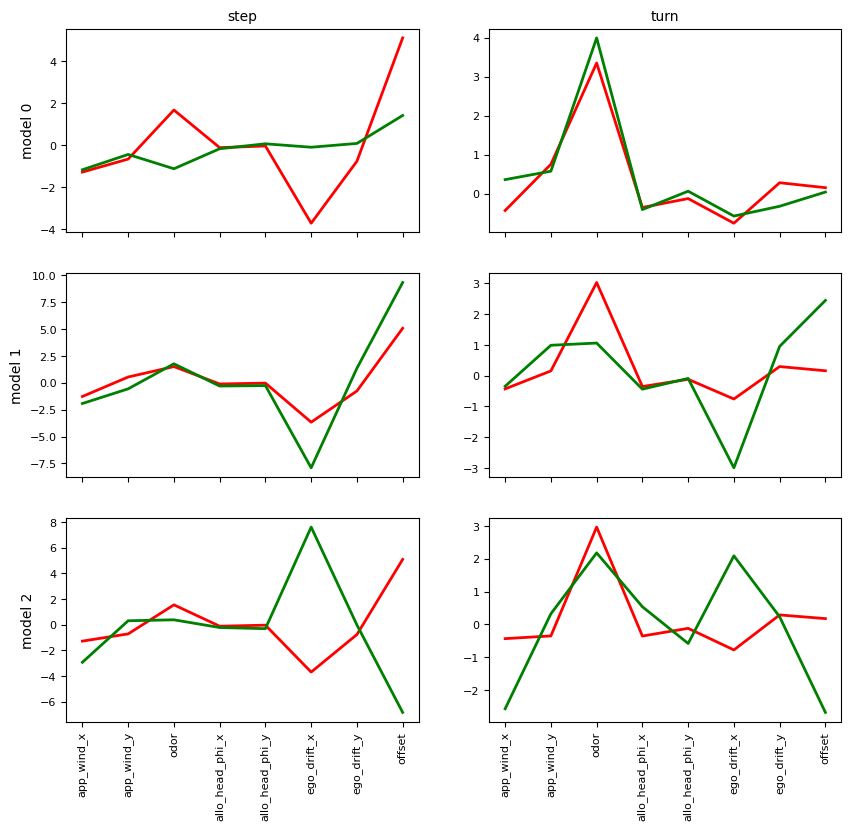

In [ ]:
for w_pred in w_pred_all:
    if w_pred.shape[1] == 2:
        w_pred_K2 = w_pred


# plot the inferred weights probabilities


fig, axes = plt.subplots(w_pred_K2.shape[0],2)
# set figure size
fig.set_size_inches(10,9)
output_names=['step', 'turn']
# set up a colors obj with 3 distinct colors , without using sns
colors = ['r', 'g', 'b']
labels = ['state 0', 'state 1', 'state 2']
for model_i in range(w_pred_K2.shape[0]):
    w_pred = w_pred_K2[model_i] # shape (3, 8, 2): K, D+1, dim_output
    for state_i in range(w_pred.shape[0]):
        for output_i in range(w_pred.shape[2]):
            ax = axes[model_i, output_i] # each model has its own row
            xlabels = ['app_wind_x', 'app_wind_y', 
                        'odor', 
                        'allo_head_phi_x', 'allo_head_phi_y', 
                        'ego_drift_x', 'ego_drift_y', 'offset'
                        # 'min_EV_zeta', 'time_since_last_wind_change', 'acceleration', 'angular_acceleration'
                        ]
            # w_pred.shape (3, 8, 2): K, D+1, dim_output
            style = '-'
            # print("w_pred[state_i,:,output_i].shape", w_pred[state_i,:,output_i].shape)
            # print("labels[state_i]", labels[state_i])
            # print("colors[state_i]", colors[state_i])
            ax.plot(w_pred[state_i,:,output_i], style,linewidth=2, color=colors[state_i], label=labels[state_i]) #,color=color[i] label=label[i],
            # label x axis by name
            ax.set_xticks(np.arange(0,len(xlabels)))
            ax.set_xticklabels(xlabels,rotation=90, fontsize=8)
            # change y ticks font
            ax.tick_params(axis='y', labelsize=8)
            # change y label font
            if output_i == 0:
                ax.set_ylabel(f"model {model_i}" , fontsize=10)
            if model_i == 0:
                ax.set_title(f'{output_names[output_i]}', fontsize=10)
            if model_i != w_pred_K2.shape[0]-1:
                ax.set_xticklabels([])


## plot all K4 models

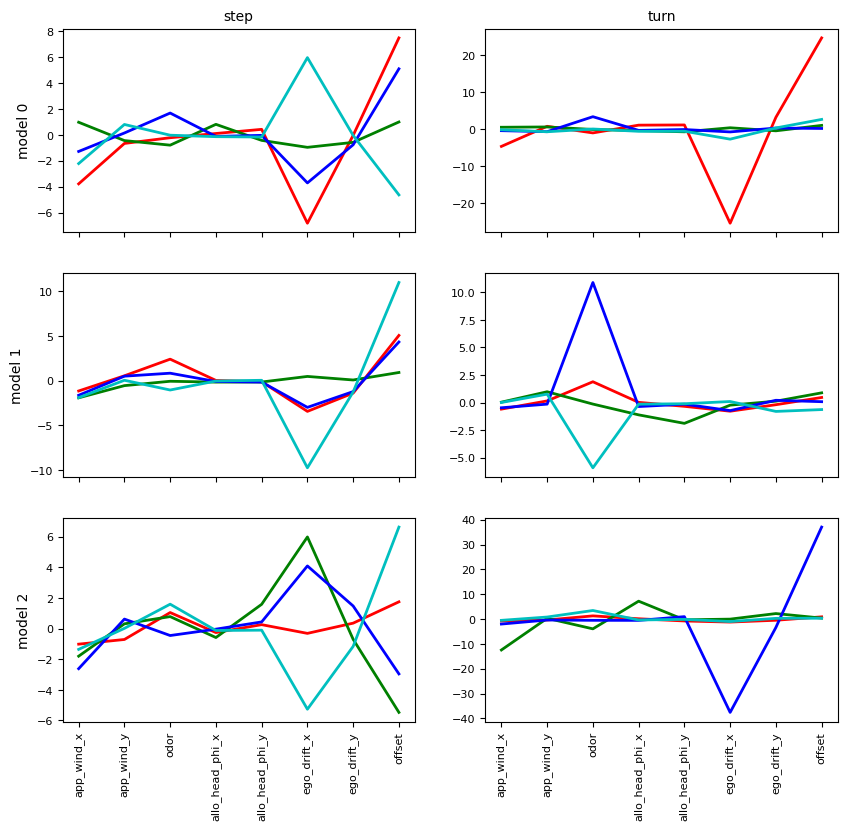

In [54]:
for w_pred in w_pred_all:
    if w_pred.shape[1] == 4:
        plot_w = w_pred


# plot the inferred weights probabilities


fig, axes = plt.subplots(plot_w.shape[0],2)
# set figure size
fig.set_size_inches(10,9)
output_names=['step', 'turn']
# set up a colors obj with 3 distinct colors , without using sns
colors = ['r', 'g', 'b', 'c']
labels = ['state 0', 'state 1', 'state 2', 'state 3']
for model_i in range(plot_w.shape[0]):
    w_pred = plot_w[model_i] # shape (3, 8, 2): K, D+1, dim_output
    for state_i in range(w_pred.shape[0]):
        for output_i in range(w_pred.shape[2]):
            ax = axes[model_i, output_i] # each model has its own row
            xlabels = ['app_wind_x', 'app_wind_y', 
                        'odor', 
                        'allo_head_phi_x', 'allo_head_phi_y', 
                        'ego_drift_x', 'ego_drift_y', 'offset'
                        # 'min_EV_zeta', 'time_since_last_wind_change', 'acceleration', 'angular_acceleration'
                        ]
            # w_pred.shape (3, 8, 2): K, D+1, dim_output
            style = '-'
            # print("w_pred[state_i,:,output_i].shape", w_pred[state_i,:,output_i].shape)
            # print("labels[state_i]", labels[state_i])
            # print("colors[state_i]", colors[state_i])
            ax.plot(w_pred[state_i,:,output_i], style,linewidth=2, color=colors[state_i], label=labels[state_i]) #,color=color[i] label=label[i],
            # label x axis by name
            ax.set_xticks(np.arange(0,len(xlabels)))
            ax.set_xticklabels(xlabels,rotation=90, fontsize=8)
            # change y ticks font
            ax.tick_params(axis='y', labelsize=8)
            # change y label font
            if output_i == 0:
                ax.set_ylabel(f"model {model_i}" , fontsize=10)
            if model_i == 0:
                ax.set_title(f'{output_names[output_i]}', fontsize=10)
            if model_i != plot_w.shape[0]-1:
                ax.set_xticklabels([])
